In [2]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

#include("hmc_mod.jl")
#include("helper_functions.jl")
include("proposals.jl")
include("mnist.jl")
include("utils.jl");

In [94]:
#Load the MNIST Data
num_samples = 100
num_classes = 3
x_train, y_train = load_mnist_train_set()
x_test, y_test = load_mnist_test_set()

x, y = balanced_set(x_train,y_train,num_samples,num_classes,2);

#Test Set
x_test, y_test = balanced_set(x_test,y_test,num_samples,num_classes);

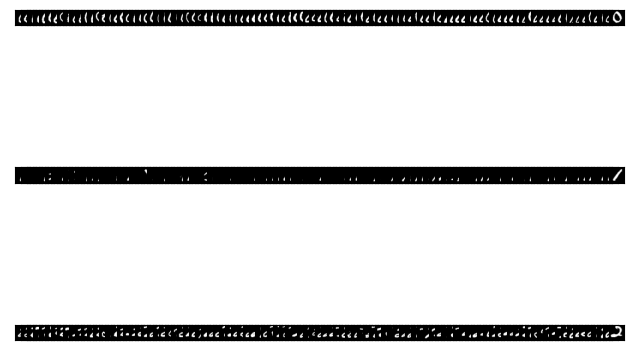

In [95]:
#Visualize Samples
x_reshaped = reshape_x(x)

nrow, ncol = num_classes,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

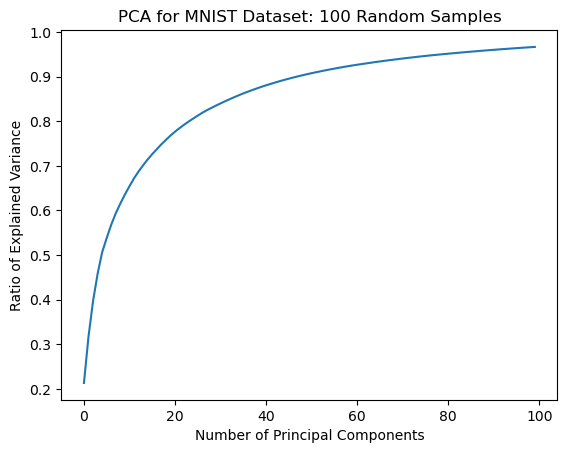

In [96]:
#Run PCA to lower dimensionality of MNIST
vars = []
x = transpose(x)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for MNIST Dataset: 100 Random Samples")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [97]:
#Get PCA Transform for x
dims = 20
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

#Testing PCA Transform
xz = transform(x_pca,transpose(x_test));

In [98]:
#One-Hot Encode Y
#yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
yt = Flux.onehotbatch(y,[:1,:2,:3]);
#Test Set
yz = y_test
#yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
yzt = Flux.onehotbatch(yz,[:1,:2,:3]);

In [128]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = num_samples #Number of samples
c = num_classes #Number of classes
d = dims #Input dimension
N = n*c #Total samples

#Network hyperparameters
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape

#Node hyperparameters
k_range = 20 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

In [157]:
#New Softmax
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(0.2.*x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

In [159]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [160]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, c)
    output_array[c] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ##################################################
    #Adapted from BH: hyperparameter schedule - Apr 3#
    ##################################################
    
    α₁ = 1 #Input Weights, Biases Shape
    β₁ = 1 #Input Weights, Biases Scale/Rate
    α₂ = 1 #Hidden & Output Weights Shape
    β₂ = k[1] #Scale Hyperparameter Based on Number of Nodes
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(c)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-2547.4395187134287
3


152

In [161]:
test_labels[:,1]

3-element Array{Float64,1}:
 0.9927743837085088
 0.0072256161093553345
 1.8213595042638558e-10

In [162]:
include("proposals.jl")
obs[(:k,1)] = 2
(best_trace,) = generate(classifier, (xt,), obs)
new_trace,q = node_birth(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

2×20 Array{Float64,2}:
 0.0304982  -0.717118  0.251575  …   0.757227   0.600186   0.989184
 0.810997   -0.908685  0.251958     -0.485775  -1.37072   -1.60029

3×20 Array{Float64,2}:
 -0.715923    0.7418    0.0564299  …   0.0772032   1.16728    0.693644
  0.0304982  -0.717118  0.251575       0.757227    0.600186   0.989184
  0.810997   -0.908685  0.251958      -0.485775   -1.37072   -1.60029

-433.8705802836514
-503.80325660702397
Old trace Accuracy: 101
New trace Accuracy: 55


In [163]:
include("proposals.jl")

println("Current k: $(best_trace[(:k,1)])")
new_trace2,q = node_death(new_trace)
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
display(reshape(new_trace2[(:W,1)], new_trace2[(:k,1)], d))
println(get_score(new_trace))
println(get_score(new_trace2))

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace2)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

3×20 Array{Float64,2}:
 -0.715923    0.7418    0.0564299  …   0.0772032   1.16728    0.693644
  0.0304982  -0.717118  0.251575       0.757227    0.600186   0.989184
  0.810997   -0.908685  0.251958      -0.485775   -1.37072   -1.60029

2×20 Array{Float64,2}:
 -0.715923   0.7418    0.0564299  …   0.0772032   1.16728   0.693644
  0.810997  -0.908685  0.251958      -0.485775   -1.37072  -1.60029

Current k: 2
-503.80325660702397
-472.8290416929587
Old trace Accuracy: 55
New trace Accuracy: 50


In [164]:
display(reshape(new_trace[(:W,2)],new_trace[(:k,2)],new_trace[(:k,1)]))
display(reshape(new_trace2[(:W,2)],new_trace2[(:k,2)],new_trace2[(:k,1)]))

3×3 Array{Float64,2}:
 -1.65444   0.193706   0.107883
 -0.441425  0.220342  -1.53068
 -0.74741   0.515436  -1.09742

3×2 Array{Float64,2}:
 -1.65444    0.107883
 -0.441425  -1.53068
 -0.74741   -1.09742

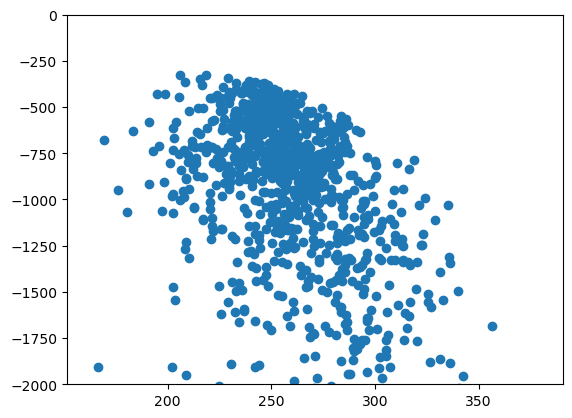

(-2000.0, 0.0)

In [165]:
#Test Likelihood
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

scores = []
accs = []
ks = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(ks,trace[(:k,1)])
    push!(scores,get_score(trace))
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
plt.ylim(-2000,0)
#println(ks)

In [ ]:
include("NUTS.jl")
(best_trace,) = generate(classifier, (xt,), obs)
l = best_trace[:l]
println(best_trace[(:k,1)])
param_selection = select()
for i=1:l+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end
traces = NUTS(best_trace, param_selection, 0.65, 100, 1, true);

In [ ]:
#Straight NUTS
include("NUTS.jl")
Δ_max = 100

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

m=2
iters=1000

(best_trace,) = generate(classifier, (xt,), obs)
best_k = best_trace[(:k,1)]
println("Starting ks: $best_k")
traces = []
push!(traces,best_trace)

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

for i=1:iters
    
    trace_star = traces[i]
    if i%10 == 0
        println("Iteration $i: $(get_score(trace_star))")
        flush(stdout)
    end
    trace_star = gibbs_hyperparameters(trace_star)
    trace_star, accepted = nuts_parameters(trace_star)

    push!(traces,trace_star)
end

In [167]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
across_iters = 1
m = 1

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            #println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function node_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:across_iters
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:across_iters
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(trace,) = generate(classifier, (xt,), obs)
#trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
traces = []

for i=1:300
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 7
1 : -678.7963131147649
2 : -679.5325976795186
3 : -678.5712920346134
4 : -678.3333180059819
5 : -678.812837635066
********** Accepted: 6 **********
6 : -594.2338413434752
********** Accepted: 5 **********
7 : -528.860737844512
********** Accepted: 4 **********
8 : -480.81180770525685
9 : -479.82409428954236
********** Accepted: 5 **********
10 : -511.0275193393997
Epoch 10 A Acceptance Probability: 40.0 %
Epoch 10 W Acceptance Probability: 10.0 %
11 : -510.264405927059
12 : -508.7936244235024
13 : -491.3633992105978
********** Accepted: 4 **********
14 : -446.35149985499856
15 : -430.7521003948664
********** Accepted: 5 **********
16 : -436.7730339917326
17 : -435.3601885947085
18 : -414.8137450304732
19 : -413.61907242545516
20 : -415.32253118770296
Epoch 20 A Acceptance Probability: 30.0 %
Epoch 20 W Acceptance Probability: 40.0 %
21 : -413.8613948304078
22 : -415.6857926397428
23 : -410.2175936582715
24 : -412.6028316008732
25 : -409.90311100039315
26 : -408.9693677663

Epoch 230 A Acceptance Probability: 3.91304347826087 %
Epoch 230 W Acceptance Probability: 63.04347826086957 %
231 : -414.03040694359237
232 : -413.54234472867876
233 : -414.4958965766289
234 : -416.3690795789673
235 : -414.15179669418296
236 : -414.60185673734037
237 : -414.6091842099909
238 : -415.47663401031167
239 : -411.9502770172782
240 : -412.29305293767356
Epoch 240 A Acceptance Probability: 3.75 %
Epoch 240 W Acceptance Probability: 63.33333333333333 %
241 : -413.36133784447685
242 : -412.5517986147297
243 : -413.48909603641374
244 : -412.82393507827544
245 : -413.38314961385566
246 : -409.4075259997678
247 : -408.8869906149027
248 : -408.4527136165211
249 : -409.4095169388876
250 : -408.82627767574974
Epoch 250 A Acceptance Probability: 3.5999999999999996 %
Epoch 250 W Acceptance Probability: 63.2 %
251 : -409.2176692223719
252 : -405.612005724182
253 : -407.51921690275174
254 : -405.7712480495288
255 : -408.0318140952881
256 : -405.5576700367438
257 : -405.76927415331545
258

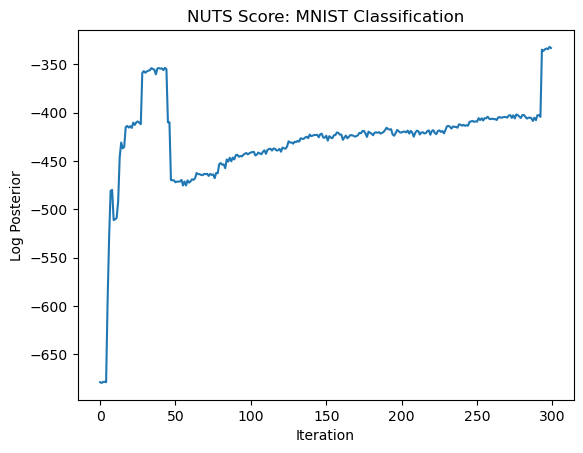

In [168]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

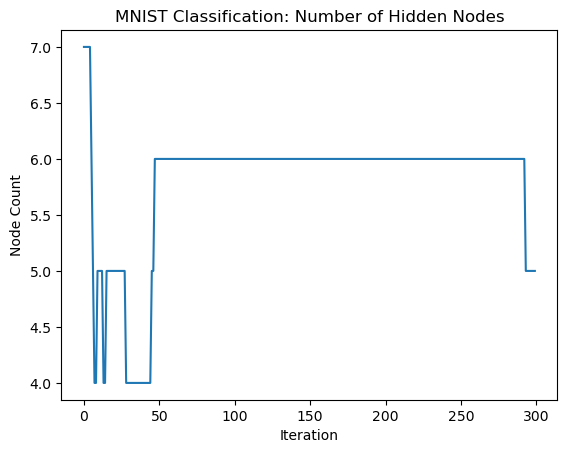

In [169]:
#Node Count Chart

plot([trace[(:k,1)] for trace in traces])
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

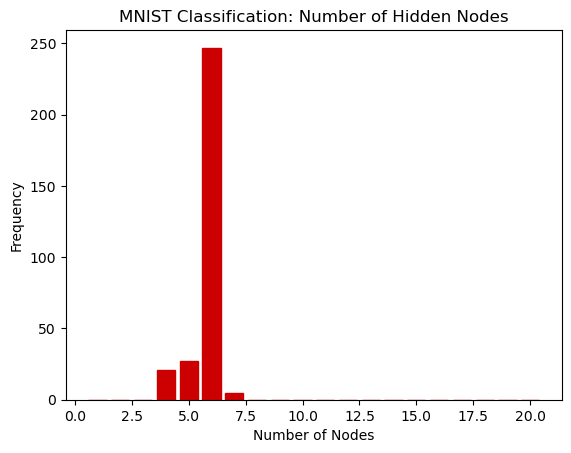

In [170]:
#Node Count Histogram

########################
#Bar Plot of l estimates
########################

ks = [traces[i][(:k,1)] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]

barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
#barlist[2].set_color([0.0,0.8,0.1])

plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency");

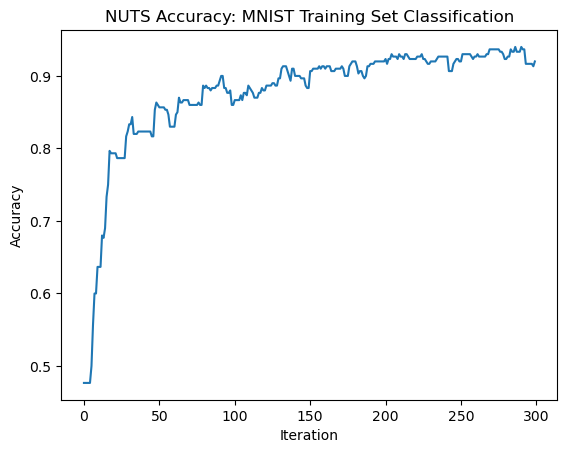

In [171]:
#Plot Training Accuracy
accs = []
dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

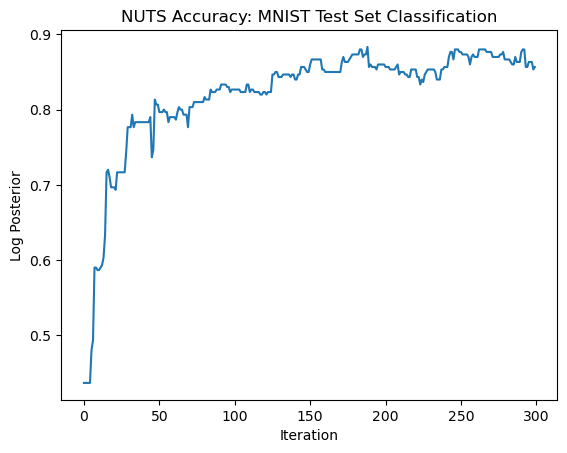

In [172]:
#Plot Testing Accuracy
accs = []
#dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xz,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    #push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

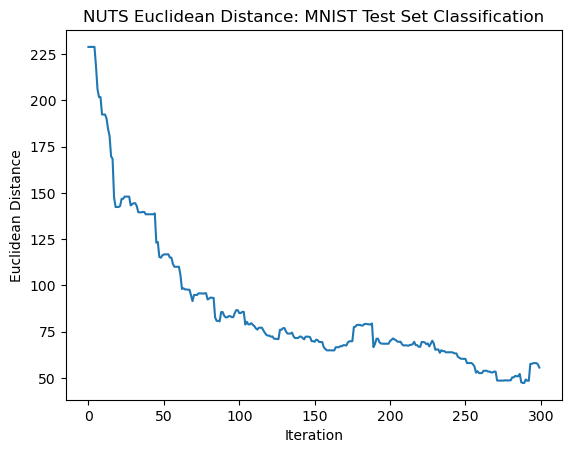

In [173]:
plot(dists)
plt.title("NUTS Euclidean Distance: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Euclidean Distance");

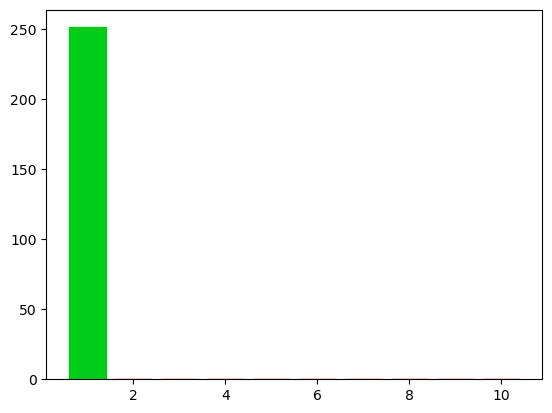

Any[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1


In [174]:
#Bar Chart of Guesses For Given Target
targets = []
target = 2
for i=50:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    push!(targets,results[target])
end
#counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
counts = [sum([targets[i] == j for i in 1:length(targets)]) for j in 1:10]

barlist=bar(1:10,counts)
for i in 1:10
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[y[target]].set_color([0.0,0.8,0.1])
println(targets)
println(y[target])

In [175]:
#Marginalize Probabilities - Train Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])

276

In [176]:
#Marginalize Probabilities - Test Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xz,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([yz[i] == guesses[i] for i=1:length(yz)])

256